# Rotten Tomatoes Movies Rating Prediction

## Table of Contents

- [Objective](#objective)
- [First Approach: Predicting Movie Status based on Numerical and Categorical Features](#first-approach)
    - [Data Preprocessing](#data-preprocessing)
    - [Decision Tree Classifier: Limited to Three Leaf Nodes](#decision-tree-three-leaf)
    - [Decision Tree Classifier: Unlimited Leaf Nodes](#decision-tree-unlimited)
    - [Random Forest Classifier](#random-forest)
    - [Random Forest Classifier with Feature Selection](#random-forest-feature-selection)
    - [Weighted Random Forest Classifier with Feature Selection](#weighted-random-forest-feature-selection)
- [Second Approach: Predicting Movie Status based on Review Sentiment](#second-approach)
    - [Random Forest](#random-forest-2)
    - [Weighted Random Forest](#weighted-random-forest)
    - [Movie Status Prediction](#movie-status-prediction)
        - ['Tron Legacy' Prediction](#tron-legacy-prediction)
        - ['The Hangover' Prediction](#hangover-prediction)
        - ['Planet of the Apes' Prediction](#planet-apes-prediction)

## Objective <a id='objective'></a>

This notebook shows the process of building a classification model to predict the labels of movies on [Rotten Tomatoes](https://www.rottentomatoes.com/), a website that aggregates and ranks reviews from critics and audiences for movies and TV shows. The labels are 'Rotten', 'Fresh', or 'Certified-Fresh'.

There are two approaches that will be used to predict a movie's status:

- by using numerical and categorical features
- by using text data (reviews from critics)

The first approach will use `rotten_tomatoes_movies.csv` and the second approach will use `rotten_tomatoes_critic_reviews_50k.csv` for data.

Here, there is a focus on predicting movie status with tree-based algorithms including decision tree and random forest.

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

## First Approach: Predicting Movie Status based on Numerical and Categorical Features <a id='first-approach'></a>

In [2]:
# Read data
df_movie = pd.read_csv('data/raw/rotten_tomatoes_movies.csv')
df_movie.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


In [3]:
# Summary of DataFrame
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17712 entries, 0 to 17711
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rotten_tomatoes_link              17712 non-null  object 
 1   movie_title                       17712 non-null  object 
 2   movie_info                        17391 non-null  object 
 3   critics_consensus                 9134 non-null   object 
 4   content_rating                    17712 non-null  object 
 5   genres                            17693 non-null  object 
 6   directors                         17518 non-null  object 
 7   authors                           16170 non-null  object 
 8   actors                            17360 non-null  object 
 9   original_release_date             16546 non-null  object 
 10  streaming_release_date            17328 non-null  object 
 11  runtime                           17398 non-null  float64
 12  prod

In [4]:
# Summary statistics
df_movie.describe()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
count,17398.000000,17668.000000,17668.000000,17416.000000,1.741500e+04,17712.000000,17712.000000,17712.000000
mean,102.214048,60.884763,57.139801,60.554260,1.439401e+05,14.586326,36.374831,20.703139
std,18.702511,28.443348,68.370047,20.543369,1.763577e+06,15.146349,52.601038,30.248435
min,5.000000,0.000000,5.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000
25%,90.000000,38.000000,12.000000,45.000000,7.075000e+02,3.000000,6.000000,3.000000
50%,99.000000,67.000000,28.000000,63.000000,4.277000e+03,8.000000,16.000000,8.000000
75%,111.000000,86.000000,75.000000,78.000000,2.498800e+04,23.000000,44.000000,24.000000
max,266.000000,100.000000,574.000000,100.000000,3.579764e+07,69.000000,497.000000,303.000000


### Data Preprocessing <a id='data-preprocessing'></a>

In [5]:
# Check `content_rating` feature
print(f'Content rating categories: {df_movie.content_rating.unique()}')

Content rating categories: ['PG' 'R' 'NR' 'G' 'PG-13' 'NC17']


[Text(0, 0, '6377'),
 Text(0, 0, '5474'),
 Text(0, 0, '2979'),
 Text(0, 0, '2168'),
 Text(0, 0, '676'),
 Text(0, 0, '38')]

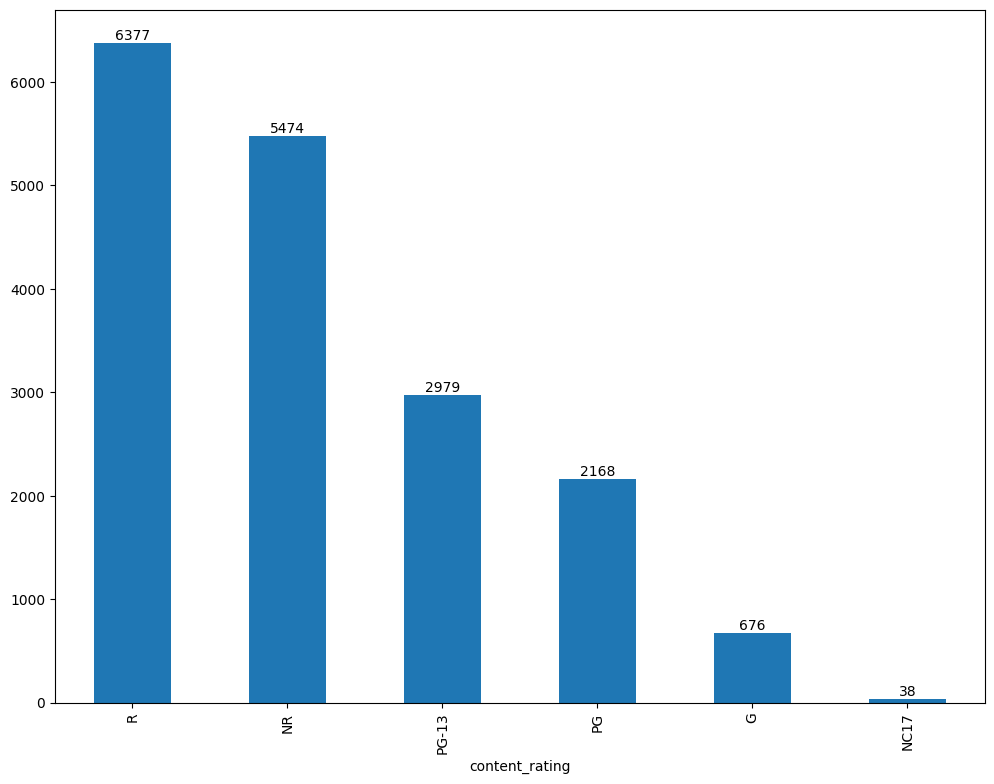

In [6]:
# Plot distribution for each category in `content_rating` feature
ax = df_movie['content_rating'].value_counts().plot(kind='bar', figsize=(12, 9))
ax.bar_label(ax.containers[0])

In [7]:
# One hot encoding `content_rating` feature
content_rating = pd.get_dummies(df_movie['content_rating'], dtype='int')
content_rating.head()

,G,NC17,NR,PG,PG-13,R
0,0,0,0,1,0,0
1,0,0,0,0,0,1
2,0,0,0,0,0,1
3,0,0,1,0,0,0
4,1,0,0,0,0,0


In [8]:
# Check `audience_status` feature
print(f'Audience status categories: {df_movie.audience_status.unique()}')

Audience status categories: ['Spilled' 'Upright' nan]


[Text(0, 0, '9390'), Text(0, 0, '7874')]

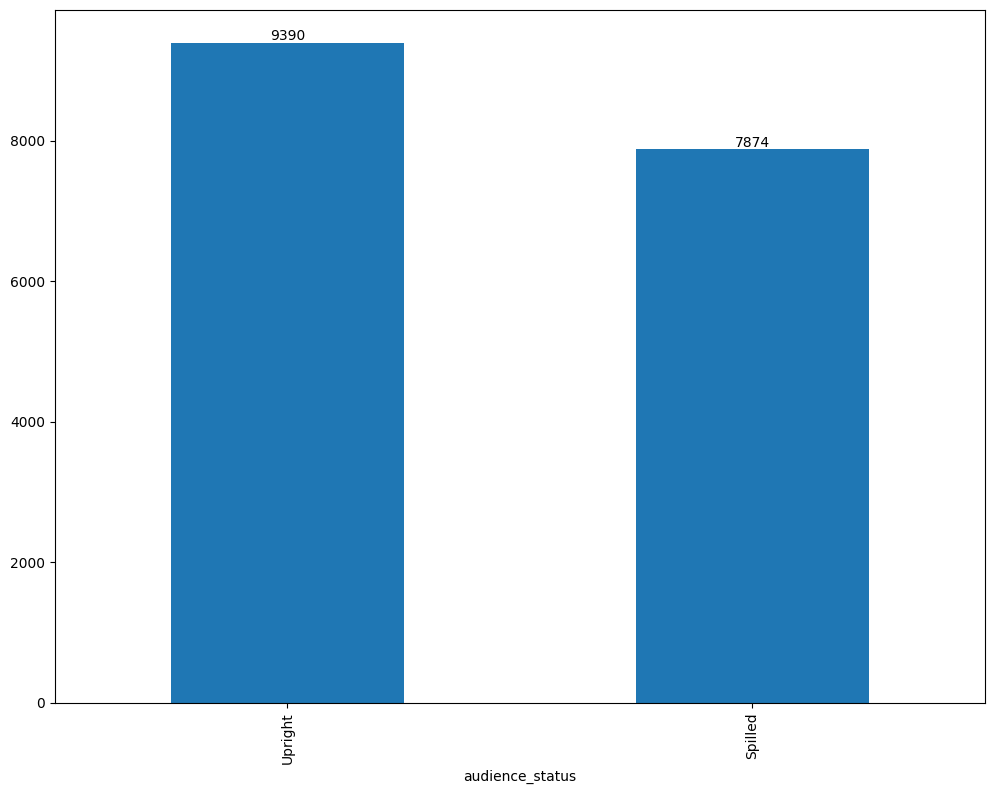

In [9]:
# Plot distribution for categories in `audience_status` feature
ax = df_movie['audience_status'].value_counts().plot(kind='bar', figsize=(12, 9))
ax.bar_label(ax.containers[0])

In [10]:
# Encode `audience status` feature with ordinal encoding
audience_status = pd.DataFrame(df_movie['audience_status'].replace(to_replace=['Spilled', 'Upright'], value=[0, 1]))
audience_status.head()

,audience_status
0,0.0
1,1.0
2,0.0
3,1.0
4,1.0


In [11]:
# Check `tomatometer_status` feature
print(f'Tomatometer status categories: {df_movie.tomatometer_status.unique()}')

Tomatometer status categories: ['Rotten' 'Certified-Fresh' 'Fresh' nan]


In [12]:
# Encode `tomatometer_status` feature with ordinal encoding
tomatometer_status = pd.DataFrame(df_movie['tomatometer_status'].replace(to_replace=['Rotten', 'Fresh', 'Certified-Fresh'], value=[0, 1, 2]))
tomatometer_status.head()

,tomatometer_status
0,0.0
1,2.0
2,1.0
3,2.0
4,1.0


In [13]:
# Concatenate all features into one DataFrame
df_feature = pd.concat(objs=[df_movie[['runtime', 'tomatometer_rating', 'tomatometer_count', 'audience_rating', 'audience_count', 'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count']],
                            content_rating, audience_status, tomatometer_status], axis=1).dropna()
df_feature.head()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,G,NC17,NR,PG,PG-13,R,audience_status,tomatometer_status
0,119.0,49.0,149.0,53.0,254421.0,43,73,76,0,0,0,1,0,0,0.0,0.0
1,90.0,87.0,142.0,64.0,11574.0,44,123,19,0,0,0,0,0,1,1.0,2.0
2,122.0,67.0,24.0,53.0,14684.0,2,16,8,0,0,0,0,0,1,0.0,1.0
3,95.0,100.0,54.0,97.0,105386.0,6,54,0,0,0,1,0,0,0,1.0,2.0
4,127.0,89.0,27.0,74.0,68918.0,5,24,3,1,0,0,0,0,0,1.0,1.0


In [14]:
# Summary statistics
df_feature.describe()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,G,NC17,NR,PG,PG-13,R,audience_status,tomatometer_status
count,17017.000000,17017.000000,17017.000000,17017.000000,1.701700e+04,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000
mean,102.296233,60.519539,57.097197,60.324499,1.471183e+05,14.765999,36.237292,20.871188,0.039314,0.002174,0.294940,0.124993,0.171593,0.366986,0.542928,0.752718
std,18.653649,28.436397,66.814580,20.480600,1.783955e+06,15.172256,51.362454,29.978900,0.194346,0.046580,0.456029,0.330720,0.377037,0.481997,0.498168,0.747250
min,5.000000,0.000000,5.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.000000,38.000000,12.000000,44.000000,7.410000e+02,3.000000,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,99.000000,66.000000,29.000000,62.000000,4.423000e+03,8.000000,17.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,111.000000,86.000000,76.000000,77.000000,2.606700e+04,23.000000,44.000000,24.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,266.000000,100.000000,535.000000,100.000000,3.579764e+07,69.000000,497.000000,303.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


[Text(0, 0, '7375'), Text(0, 0, '6475'), Text(0, 0, '3167')]

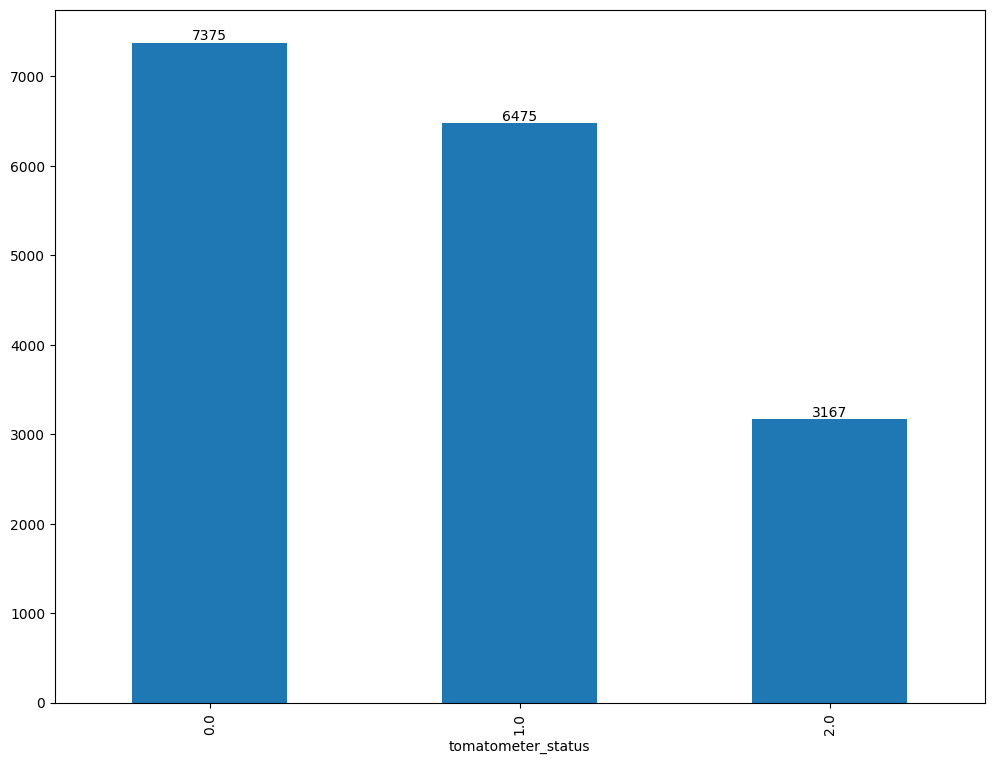

In [15]:
# Plot distribution for categories in `tomatometer_status`, target variable
ax = df_feature['tomatometer_status'].value_counts().plot(kind='bar', figsize=(12, 9))
ax.bar_label(ax.containers[0])

In [16]:
# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(df_feature.drop(columns='tomatometer_status'), df_feature['tomatometer_status'], test_size=0.2, random_state=42)
print(f'Size of training data: {len(X_train)} rows')
print(f'Size of test data: {len(X_test)} rows')

Size of training data: 13613 rows
Size of test data: 3404 rows


### Decision Tree Classifier: Limited to Three Leaf Nodes <a id='decision-tree-three-leaf'></a>

In [17]:
# Initiate Decision Tree Classifier with max leaf nodes at 3
tree_3_leaf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=2)

# Train classifier on training data
tree_3_leaf.fit(X_train, y_train)

# Make predictions with test data
y_predict = tree_3_leaf.predict(X_test)

# Print accuracy and classification report on test data
print(f'Accuracy score: {accuracy_score(y_test, y_predict)}')
print(classification_report(y_test, y_predict))

Accuracy score: 0.9462397179788484
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.97      0.88      0.93      1286
         2.0       0.80      0.95      0.87       630

    accuracy                           0.95      3404
   macro avg       0.92      0.94      0.93      3404
weighted avg       0.95      0.95      0.95      3404



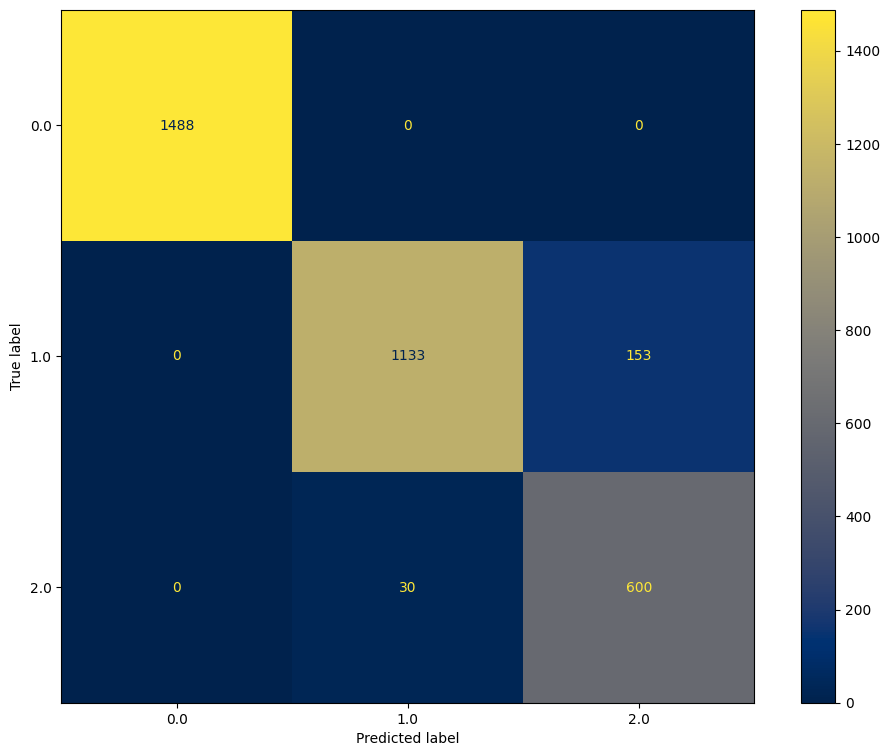

In [18]:
# Plot confusion matrix on test data
cm = confusion_matrix(y_test, y_predict, labels=tree_3_leaf.classes_)
fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_3_leaf.classes_)
disp.plot(ax=ax, cmap='cividis')
plt.show()

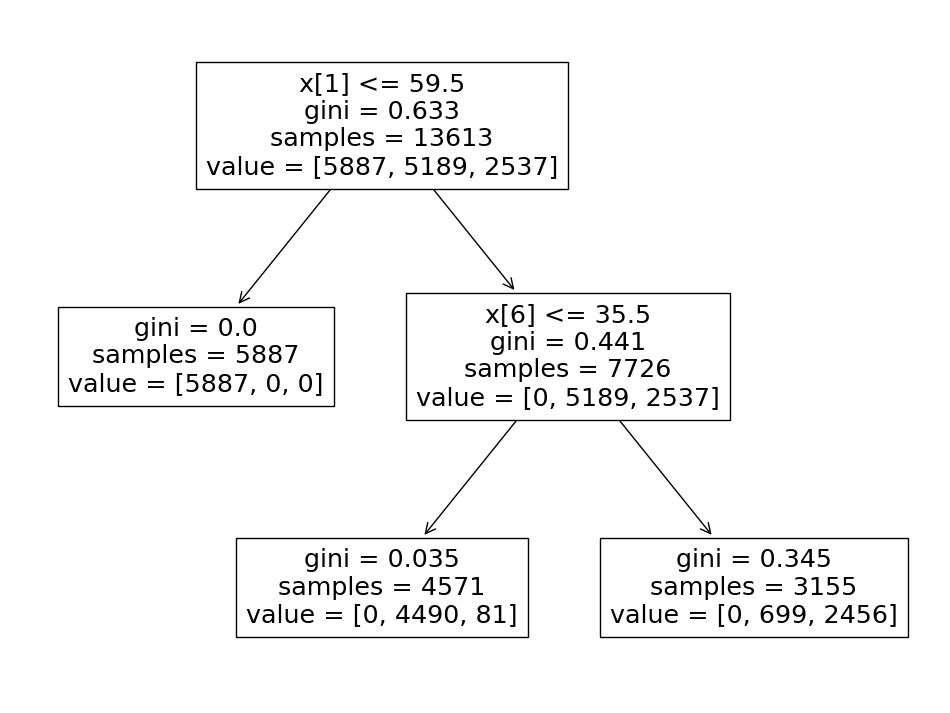

In [19]:
# Plot decision logic of decision tree model
fig, ax = plt.subplots(figsize=(12, 9))
plot_tree(tree_3_leaf, ax=ax)
plt.show()

### Decision Tree Classifier: Unlimited Leaf Nodes <a id='decision-tree-unlimited'></a>

In [20]:
# Initiate Decision Tree Classifier with default hyperparameter settings
tree = DecisionTreeClassifier(random_state=2)

# Train classifier on training data
tree.fit(X_train, y_train)

# Make predictions with test data
y_predict = tree.predict(X_test)

# Print accuracy and classification report on test data
print(f'Accuracy score: {accuracy_score(y_test, y_predict)}')
print(classification_report(y_test, y_predict))

Accuracy score: 0.9900117508813161
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      0.99      0.99      1286
         2.0       0.97      0.97      0.97       630

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



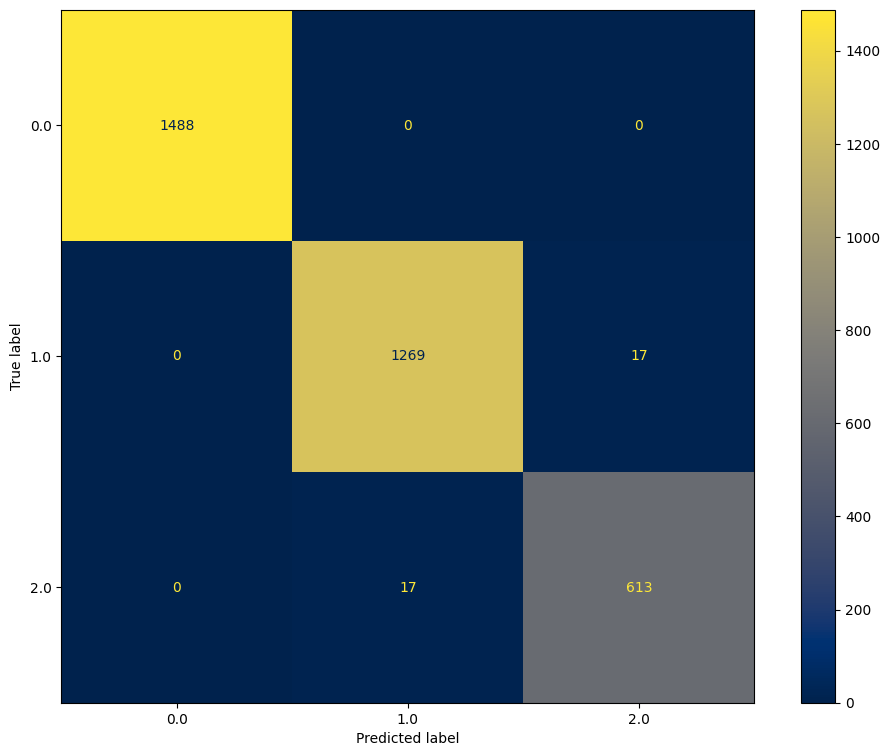

In [21]:
# Plot confusion matrix on test data
cm = confusion_matrix(y_test, y_predict, labels=tree.classes_)
fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree.classes_)
disp.plot(ax=ax, cmap='cividis')
plt.show()

### Random Forest Classifier <a id='random-forest'></a>

In [22]:
# Initiate Random Forest Classifier
rf = RandomForestClassifier(random_state=2)

# Train classifier on training data
rf.fit(X_train, y_train)

# Make predictions with test data
y_predict = rf.predict(X_test)

# Print accuracy and classification report on test data
print(f'Accuracy score: {accuracy_score(y_test, y_predict)}')
print(classification_report(y_test, y_predict))

Accuracy score: 0.9908930669800236
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      0.99      0.99      1286
         2.0       0.98      0.97      0.98       630

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



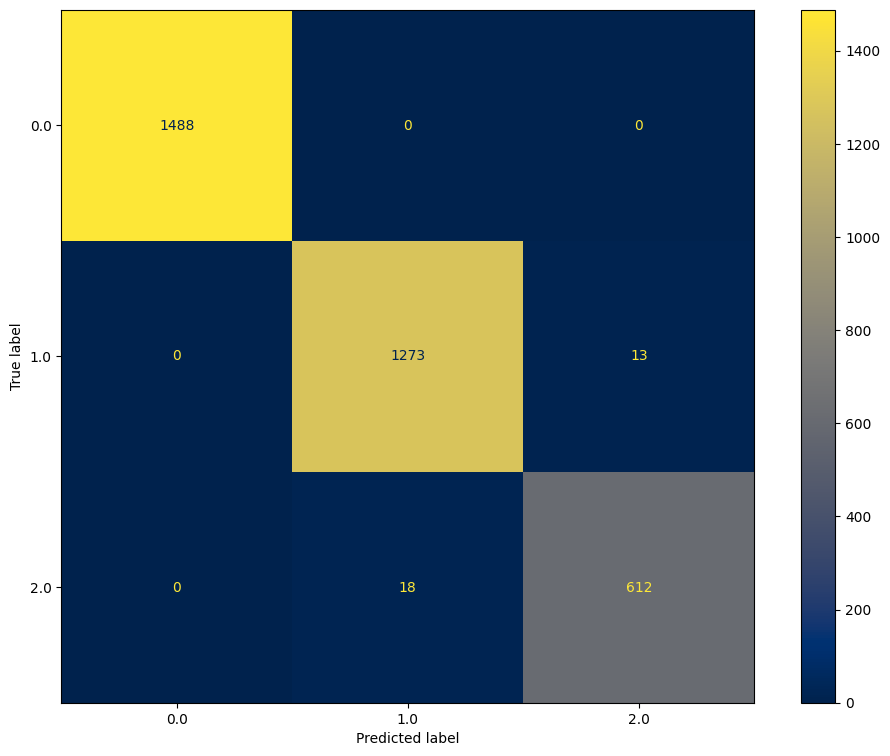

In [23]:
# Plot confusion matrix on test data
cm = confusion_matrix(y_test, y_predict, labels=rf.classes_)
fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(ax=ax, cmap='cividis')
plt.show()

In [24]:
# Get feature importance
feature_importance = rf.feature_importances_

# Print feature importance
for feature, importance in zip(X_train.columns, feature_importance):
    print(f'{feature} = {importance}')

runtime = 0.0061295693480302215
tomatometer_rating = 0.4751025864067028
tomatometer_count = 0.09895425717250429
audience_rating = 0.05389101976402856
audience_count = 0.016289896938110955
tomatometer_top_critics_count = 0.03605739578773787
tomatometer_fresh_critics_count = 0.14158242877024638
tomatometer_rotten_critics_count = 0.1314030539462201
G = 0.00029824734631526663
NC17 = 1.7090610669550172e-05
NR = 0.008710731204885382
PG = 0.0005762363713202383
PG-13 = 0.002531466583040527
R = 0.0022318936876928337
audience_status = 0.026224126062495294


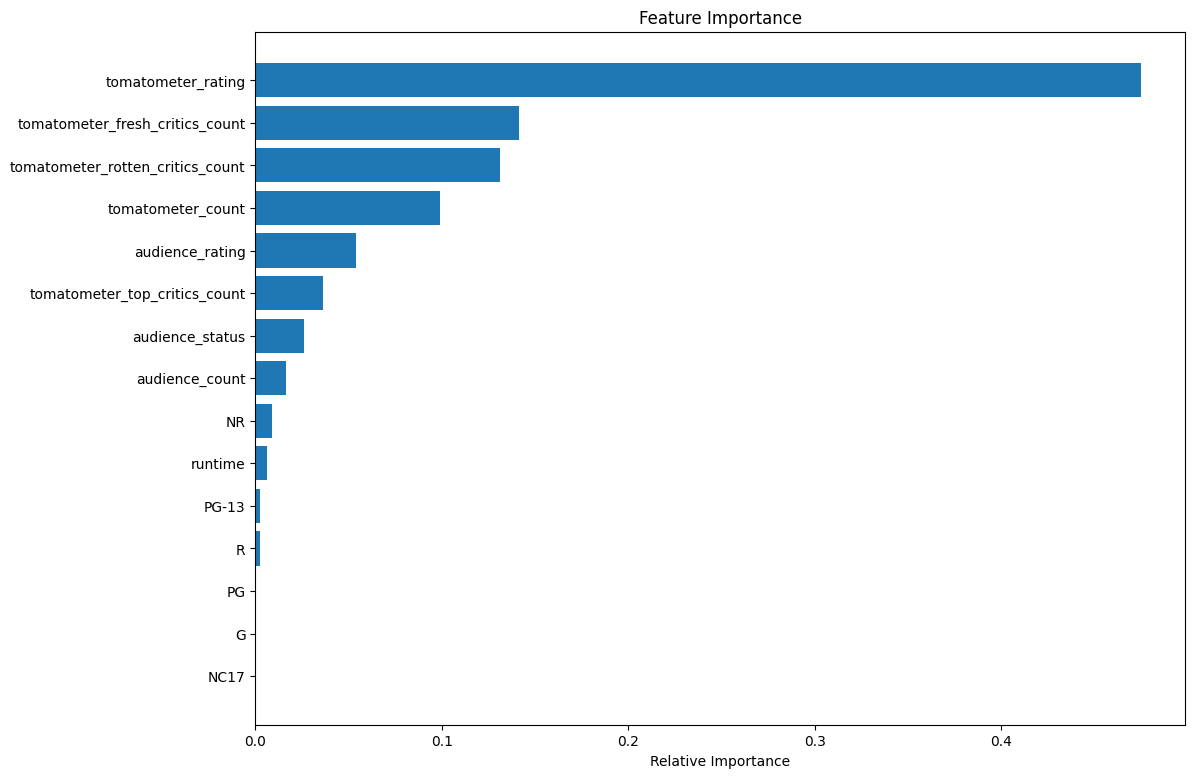

In [25]:
# Return indices that sort array
indices = np.argsort(a=feature_importance)

# Plot features from most to least important
plt.figure(figsize=(12, 9))
plt.barh(y=range(len(indices)), width=feature_importance[indices], align='center')
plt.yticks(ticks=range(len(indices)), labels=X_train.columns[indices])
plt.xlabel(xlabel='Relative Importance')
plt.title(label='Feature Importance')
plt.show()

### Random Forest Classifier with Feature Selection <a id='random-forest-feature-selection'></a>

In [26]:
# Split data into training and test data after feature selection
X_train, X_test, y_train, y_test = train_test_split(df_feature.drop(columns=['tomatometer_status', 'NR', 'runtime', 'PG-13', 'R', 'PG', 'G', 'NC17']), df_feature['tomatometer_status'], test_size=0.2, random_state=42)
print(f'Size of training data: {len(X_train)} rows')
print(f'Size of test data: {len(X_test)} rows')

Size of training data: 13613 rows
Size of test data: 3404 rows


In [27]:
# Initiate Random Forest Classifier
rf = RandomForestClassifier(random_state=2)

# Train classifier on training data
rf.fit(X_train, y_train)

# Make predictions with test data
y_predict = rf.predict(X_test)

# Print accuracy and classification report on test data
print(f'Accuracy score: {accuracy_score(y_test, y_predict)}')
print(classification_report(y_test, y_predict))

Accuracy score: 0.9917743830787309
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      0.99      0.99      1286
         2.0       0.98      0.97      0.98       630

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



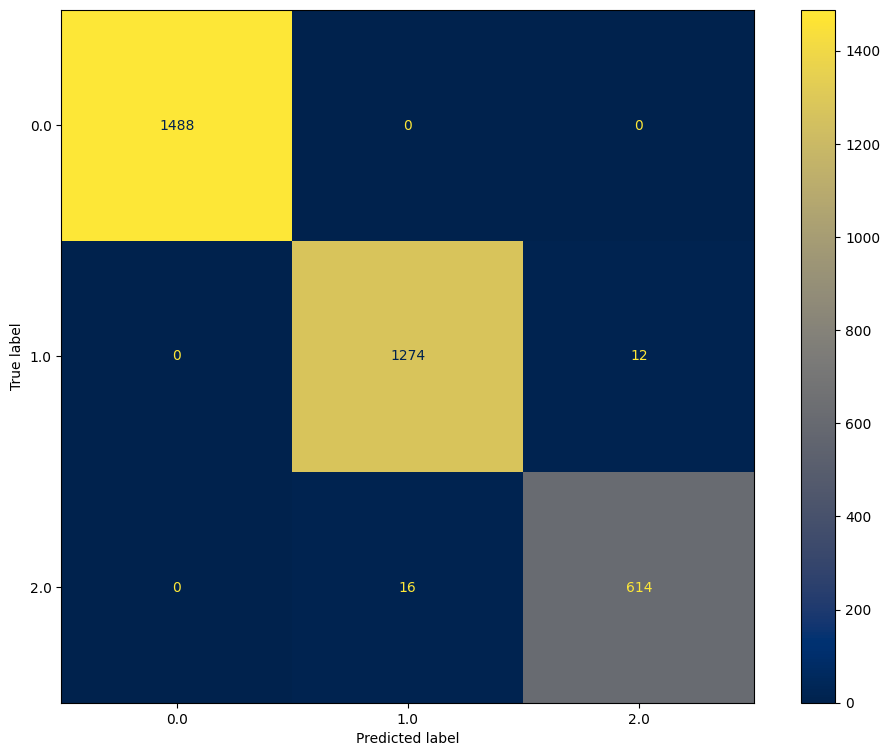

In [28]:
# Plot confusion matrix on test data
cm = confusion_matrix(y_test, y_predict, labels=rf.classes_)
fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(ax=ax, cmap='cividis')
plt.show()

### Weighted Random Forest Classifier with Feature Selection <a id='weighted-random-forest-feature-selection'></a>

In [29]:
# Compute class weight for target variable, `tomatometer_status`
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(df_feature['tomatometer_status']), y=df_feature['tomatometer_status'])

# Store values in dictionary
class_weight_dict = dict(enumerate(class_weight))

class_weight_dict

{0: 0.7691299435028248, 1: 0.8760360360360361, 2: 1.7910746237238186}

In [30]:
# Initiate Random Forest Classifier with class weights
rf_weighted = RandomForestClassifier(class_weight=class_weight_dict, random_state=2)

# Train classifier on training data
rf_weighted.fit(X_train, y_train)

# Make predictions with test data
y_predict = rf_weighted.predict(X_test)

# Print accuracy and classification report on test data
print(f'Accuracy score: {accuracy_score(y_test, y_predict)}')
print(classification_report(y_test, y_predict))

Accuracy score: 0.9926556991774383
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      0.99      0.99      1286
         2.0       0.98      0.98      0.98       630

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



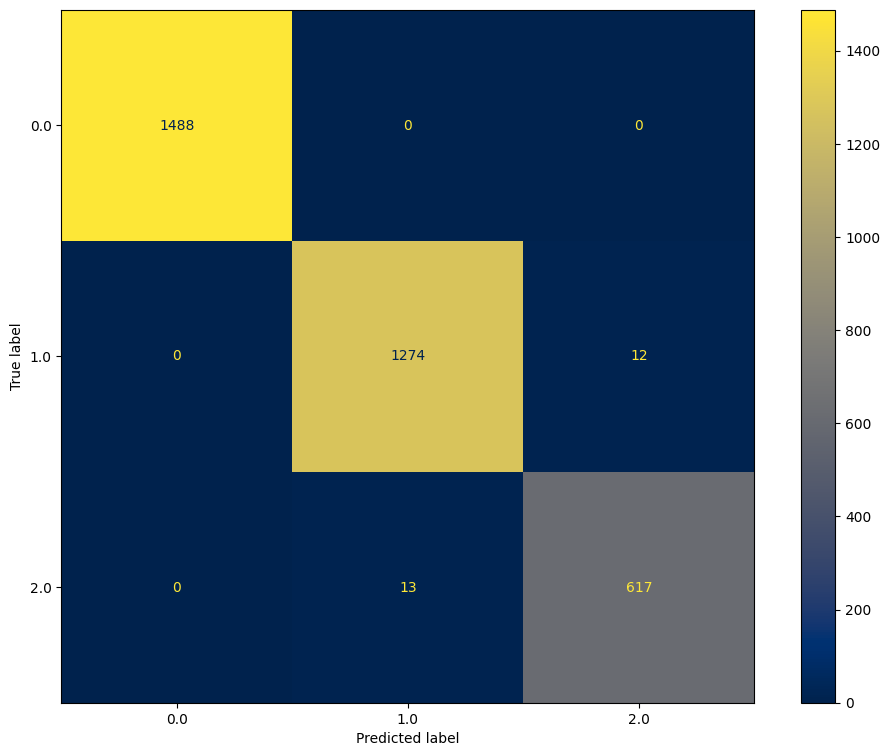

In [31]:
# Plot confusion matrix on test data
cm = confusion_matrix(y_test, y_predict, labels=rf_weighted.classes_)
fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_weighted.classes_)
disp.plot(ax=ax, cmap='cividis')
plt.show()

## Second Approach: Predicting Movie Status based on Review Sentiment <a id='second-approach'></a>

In [32]:
# Read data
df_critics = pd.read_csv('data/raw/rotten_tomatoes_critic_reviews_50k.csv')
df_critics.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [33]:
# Merge critics and movie DataFrames
df_merged = df_critics.merge(right=df_movie, how='inner', on='rotten_tomatoes_link')
df_merged = df_merged[['rotten_tomatoes_link', 'movie_title', 'review_content', 'review_type', 'tomatometer_status']]

In [34]:
df_merged.head()

,rotten_tomatoes_link,movie_title,review_content,review_type,tomatometer_status
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,A fantasy adventure that fuses Greek mythology...,Fresh,Rotten
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Uma Thurman as Medusa, the gorgon with a coiff...",Fresh,Rotten
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,With a top-notch cast and dazzling special eff...,Fresh,Rotten
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Whether audiences will get behind The Lightnin...,Fresh,Rotten
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,What's really lacking in The Lightning Thief i...,Rotten,Rotten


In [35]:
# Drop rows with missing reviews
df_merged = df_merged.dropna(subset='review_content')

[Text(0, 0, '25276'), Text(0, 0, '15919')]

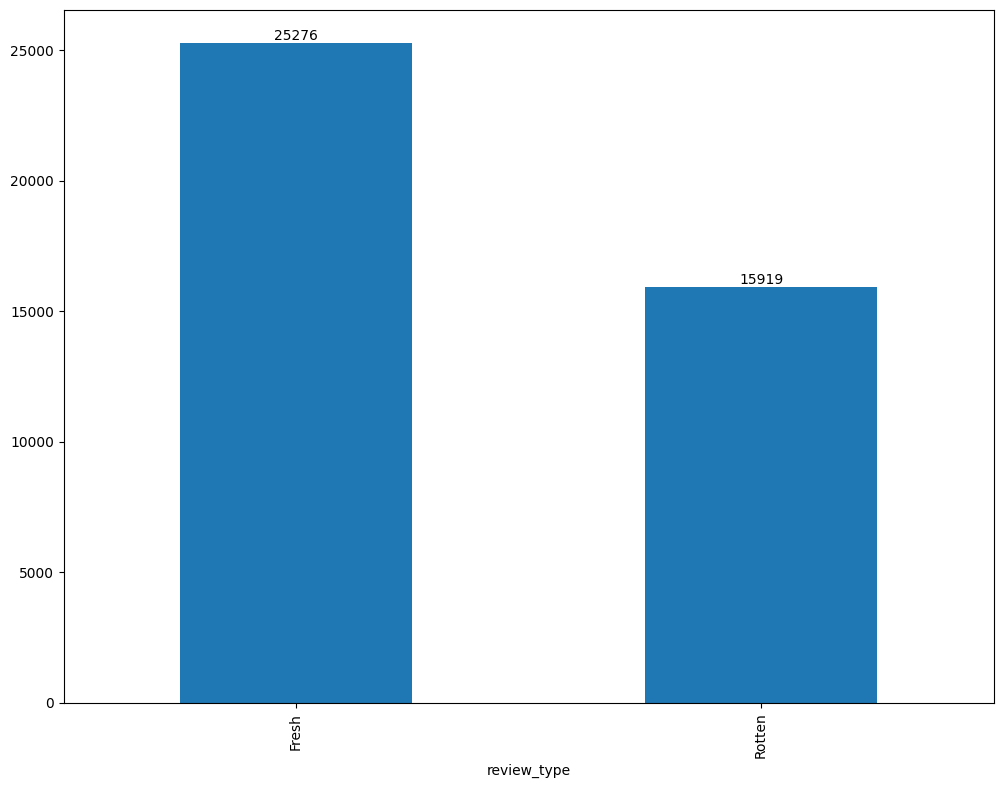

In [36]:
# Plot distribution of `review_type` feature
ax = df_merged['review_type'].value_counts().plot(kind='bar', figsize=(12, 9))
ax.bar_label(ax.containers[0])

In [37]:
# Encode `review_type` feature
review_type = pd.DataFrame(df_merged['review_type'].replace(to_replace=['Rotten', 'Fresh'], value=[0, 1]))
review_type.head()

,review_type
0,1
1,1
2,1
3,1
4,0


In [38]:
# Create final DataFrame
df_feature_critics = pd.concat(objs=[df_merged[['review_content']], review_type], axis=1).dropna()
df_feature_critics.head()

,review_content,review_type
0,A fantasy adventure that fuses Greek mythology...,1
1,"Uma Thurman as Medusa, the gorgon with a coiff...",1
2,With a top-notch cast and dazzling special eff...,1
3,Whether audiences will get behind The Lightnin...,1
4,What's really lacking in The Lightning Thief i...,0


In [39]:
# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(df_feature_critics['review_content'], df_feature_critics['review_type'], test_size=0.2, random_state=42)

### Random Forest <a id='random-forest-2'></a>

In [40]:
# Instantiate vectorizer class
vectorizer = CountVectorizer(min_df=1)

# Transform training data
X_train_vec = vectorizer.fit_transform(X_train).toarray()

# Initialize random forest classifier
rf = RandomForestClassifier(random_state=2)

# Train classifier on training data
rf.fit(X_train_vec, y_train)

# Make predictions on test data
X_test_vec = vectorizer.transform(X_test).toarray()
y_predicted = rf.predict(X_test_vec)

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.74      0.47      0.58      3237
           1       0.72      0.89      0.80      5002

    accuracy                           0.73      8239
   macro avg       0.73      0.68      0.69      8239
weighted avg       0.73      0.73      0.71      8239



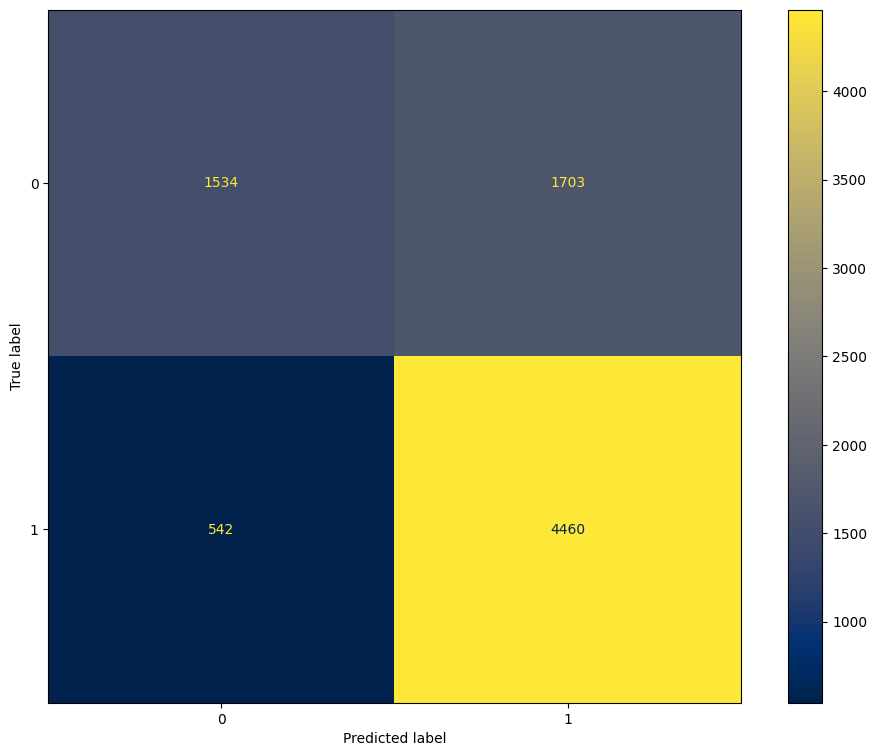

In [41]:
# Plot confusion matrix on test data
cm = confusion_matrix(y_test, y_predicted, labels=rf.classes_)
fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(ax=ax, cmap='cividis')
plt.show()

### Weighted Random Forest <a id='weighted-random-forest'></a>

In [42]:
# Compute class weight for target variable, `review_type`
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(df_feature_critics['review_type']), y=df_feature_critics['review_type'])

# Store values in dictionary
class_weight_dict = dict(enumerate(class_weight))

class_weight_dict

{0: 1.2938940888246748, 1: 0.8149034657382497}

In [43]:
# Instantiate vectorizer class
vectorizer = CountVectorizer(min_df=1)

# Transform training data
X_train_vec = vectorizer.fit_transform(X_train).toarray()

# Initialize random forest classifier
rf_weighted = RandomForestClassifier(class_weight=class_weight_dict, random_state=2)

# Train classifier on training data
rf_weighted.fit(X_train_vec, y_train)

# Make predictions on test data
X_test_vec = vectorizer.transform(X_test).toarray()
y_predicted = rf_weighted.predict(X_test_vec)

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.71      0.55      0.62      3237
           1       0.75      0.85      0.80      5002

    accuracy                           0.74      8239
   macro avg       0.73      0.70      0.71      8239
weighted avg       0.73      0.74      0.73      8239



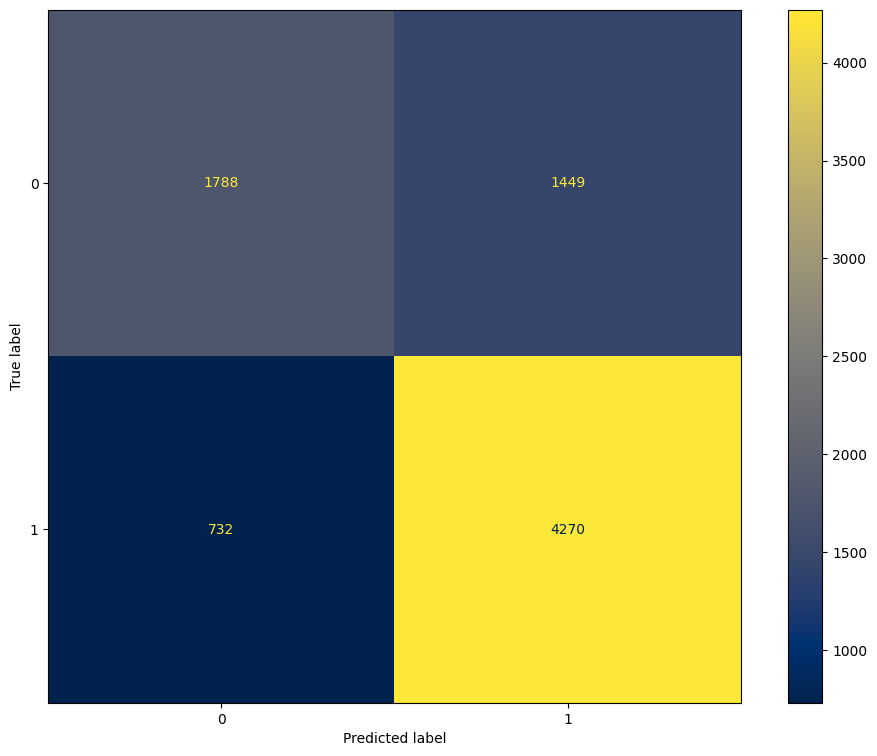

In [44]:
# Plot confusion matrix on test data
cm = confusion_matrix(y_test, y_predicted, labels=rf_weighted.classes_)
fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_weighted.classes_)
disp.plot(ax=ax, cmap='cividis')
plt.show()

### Movie Status Prediction <a id='movie-status-prediction'></a>

In [45]:
# Create function for movie status prediction
def predict_movie_status(prediction):
    """
    Assign label 'Fresh' or 'Rotten' based on prediction
    """
    positive_percentage = (prediction == 1).mean() * 100
    
    prediction = 'Fresh' if positive_percentage >= 60 else 'Rotten'
    
    print(f'Positive review: {positive_percentage:.2f}%')
    print(f'Movie status: {prediction}')

In [46]:
df_merged.groupby(by='movie_title')['review_content'].count().nlargest(n=20)

movie_title
10 Cloverfield Lane           309
Public Enemies                275
Tron Legacy                   242
The Hangover                  235
The Kids Are All Right        224
The Road                      215
Hamlet                        208
Body of Lies                  204
The Ghost Writer              204
Predators                     201
Disney's A Christmas Carol    198
Pearl Harbor                  194
Planet of the Apes            188
The Proposal                  185
Land of the Lost              181
The Happening                 181
Winter's Bone                 174
Going the Distance            172
The Women                     169
21                            165
Name: review_content, dtype: int64

#### 'Tron Legacy' Prediction <a id='tron-legacy-prediction'></a>

In [47]:
# Get all reviews of Tron Legacy movie
df_tron = df_merged[df_merged['movie_title'] == 'Tron Legacy']
df_tron.head()

,rotten_tomatoes_link,movie_title,review_content,review_type,tomatometer_status
13447,m/10011582-TRON_legacy,Tron Legacy,While 21st-century effects and a cutting-edge ...,Fresh,Rotten
13448,m/10011582-TRON_legacy,Tron Legacy,"If you're a fan like me, it's worth seeing for...",Fresh,Rotten
13449,m/10011582-TRON_legacy,Tron Legacy,"Whereas 3D has quickly become a dirty, corpora...",Fresh,Rotten
13450,m/10011582-TRON_legacy,Tron Legacy,Tron: Legacy is an exciting and beautiful film...,Fresh,Rotten
13451,m/10011582-TRON_legacy,Tron Legacy,It all ends up being a half-hour too much of a...,Rotten,Rotten


In [48]:
# Get prediction
y_predicted_tron = rf_weighted.predict(vectorizer.transform(df_tron['review_content']).toarray())
predict_movie_status(y_predicted_tron)

Positive review: 52.89%
Movie status: Rotten


In [49]:
# Get true label
df_merged[df_merged['movie_title'] == 'Tron Legacy']['tomatometer_status'].iloc[0]

'Rotten'

#### 'The Hangover' Prediction <a id='hangover-prediction'></a>

In [50]:
# Get all reviews of The Hangover movie
df_hang = df_merged[df_merged['movie_title'] == 'The Hangover']
df_hang.head()

,rotten_tomatoes_link,movie_title,review_content,review_type,tomatometer_status
11536,m/10010667-hangover,The Hangover,I loved Fat Jesus. A comedy that's funny and n...,Fresh,Certified-Fresh
11537,m/10010667-hangover,The Hangover,"Head-poundingly (in a good way), sidesplitting...",Fresh,Certified-Fresh
11538,m/10010667-hangover,The Hangover,Proudly inappropriate and buoyed by both a cle...,Fresh,Certified-Fresh
11539,m/10010667-hangover,The Hangover,The Hangover is surprisingly clever as well as...,Fresh,Certified-Fresh
11540,m/10010667-hangover,The Hangover,"Miraculously, we still like Alan and Stu and P...",Fresh,Certified-Fresh


In [51]:
# Get prediction
y_predicted_hang = rf_weighted.predict(vectorizer.transform(df_hang['review_content']).toarray())
predict_movie_status(y_predicted_hang)

Positive review: 77.45%
Movie status: Fresh


In [52]:
# Get true label
df_merged[df_merged['movie_title'] == 'The Hangover']['tomatometer_status'].iloc[0]

'Certified-Fresh'

#### 'Planet of the Apes' Prediction <a id='planet-apes-prediction'></a>

In [53]:
# Get all reviews of Planet of the Apes movie
df_planet = df_merged[df_merged['movie_title'] == 'Planet of the Apes']
df_planet.head()

,rotten_tomatoes_link,movie_title,review_content,review_type,tomatometer_status
24805,m/1016397-planet_of_the_apes,Planet of the Apes,...an above-average science-fiction movie in s...,Fresh,Certified-Fresh
24806,m/1016397-planet_of_the_apes,Planet of the Apes,A magnificently indignant Heston ... wrestles ...,Fresh,Certified-Fresh
24807,m/1016397-planet_of_the_apes,Planet of the Apes,This fascinating premise is exploited to the f...,Fresh,Certified-Fresh
24808,m/1016397-planet_of_the_apes,Planet of the Apes,Examined difficult issues like bigotry and evo...,Fresh,Certified-Fresh
24809,m/1016397-planet_of_the_apes,Planet of the Apes,This classic sci-fi ape picture leaves its imi...,Fresh,Certified-Fresh


In [54]:
# Get prediction
y_predicted_planet = rf_weighted.predict(vectorizer.transform(df_planet['review_content']).toarray())
predict_movie_status(y_predicted_planet)

Positive review: 59.04%
Movie status: Rotten


In [55]:
# Get true label
df_merged[df_merged['movie_title'] == 'Planet of the Apes']['tomatometer_status'].iloc[0]

'Certified-Fresh'

This notebook was inspired by the [Rotten Tomatoes Movies Rating Prediction](https://platform.stratascratch.com/data-projects/rotten-tomatoes-movies-rating-prediction) data project on [StrataScratch](https://www.stratascratch.com/).